In [15]:
from numpy import random
import pandas as pd
import pygraphviz as pgv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


class miuPuzzle:
    
    def __init__(self, axiom):
        self.axiom = axiom


    def rule_one_possible(self, string):
        
        # If the last letter of the current string is I, rule 1 can be applied
        
        if string[-1:] == 'I':
            return True  
        else:
            return False
    
    
    def rule_two_possible(self, string):
        
        # If the first letter of the current string is M, rule 2 can be applied
        
        if string[:1] == 'M':
            return True
        else:
            return False
    
    
    def rule_three_possible(self, string):
        
        # If the current string contains III, rule 3 can be applied
         
        if string.find('III') != -1:
            return True
        else:
            return False
        
    
    def rule_four_possible(self, string):
        
        # If the current string contains UU, rule 4 can be applied
        
        if string.find('UU') != -1:
            return True
        else:
            return False    

    
    def rule_three_indices(self, string):
        
        # Returns the indices, if any, at which rule three can be applied to a string
        
        indices = [index for index, char in enumerate(string) if string.startswith('III', index)]
    
        return indices
    
    
    def get_options(self, string):
    
        options = dict()
    
        if self.rule_one_possible(string):
            options[self.apply_rule_one(string)] = '1'
    
        if self.rule_two_possible(string):
            options[self.apply_rule_two(string)] = '2'
    
        if self.rule_three_possible(string):
            for index in self.rule_three_indices(string):
                options[self.apply_rule_three(string, index)] = f'3i{index}'
            
        if self.rule_four_possible(string):
            options[self.apply_rule_four(string)] = '4'
    
        return options
    
        
    def apply_rule_one(self, string):
        
        return f'{string}U'
    
    
    def apply_rule_two(self, string):
        
        return f'{string}{string[1:]}'
    
    
    def apply_rule_three(self, string, index):
        
        return f'{string[:index]}U{string[index+3:]}'
    
    
    def apply_rule_four(self, string):
        
        """
        The output of rule four is invariant under which index it is applied at, so just apply it
        at the first available index
        """
        
        index = string.find('II')
        
        return f'{string[:index]}{string[index+2:]}'
    
    
    def random_traversal(self, string, num_steps):
    
        # take a random walk through the local network 

        path = dict()
        rules = [None,]
        strings = [string,]

        i=0
        while i < num_steps:

            options = self.get_options(string)

            string = random.choice(list(options.keys()))
            rule = options[string]

            strings.append(string)
            rules.append(rule)

            i+=1

        path['rules'] = rules
        path['strings'] = strings

        return path


    def discover_local_network(self, string, num_steps):

        nodes = set([string,])
        edges = dict()

        i=0
        while i<num_steps:

            new_neighbours = []
            for node in nodes:

                neighbour_rule_pairs = self.get_options(node)

                for neighbour_rule_pair in neighbour_rule_pairs.items():

                    edges[tuple([node, neighbour_rule_pair[0]])] = neighbour_rule_pair[1]

                    new_neighbours.append(neighbour_rule_pair[0])

            for new_neighbour in new_neighbours:
                nodes.add(new_neighbour)

            i+=1

        network = dict()
        network['nodes'] = nodes
        network['edges'] = edges

        return network


    def get_adjacency_matrix(self, network):
    
        adjacency = pd.DataFrame(0, index=network['nodes'], columns=network['nodes'])
    
        for edge in network['edges'].items():
            adjacency.loc[edge[0][1], edge[0][0]] = edge[1]
        
        return adjacency


    def plot_network(self, network):
    
        plt.rcParams['figure.dpi'] = 400
        
        dag = pgv.AGraph(directed=True, overlap='false', splines='true')
        
        for node in network['nodes']:
            dag.add_node(node)
        
        for edge in network['edges'].items():
            dag.add_edge(edge[0], label=edge[1], color='red')
        
        dag.layout(prog='neato')  #neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
        dag.draw('dag.png')
        
        img = mpimg.imread('dag.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        

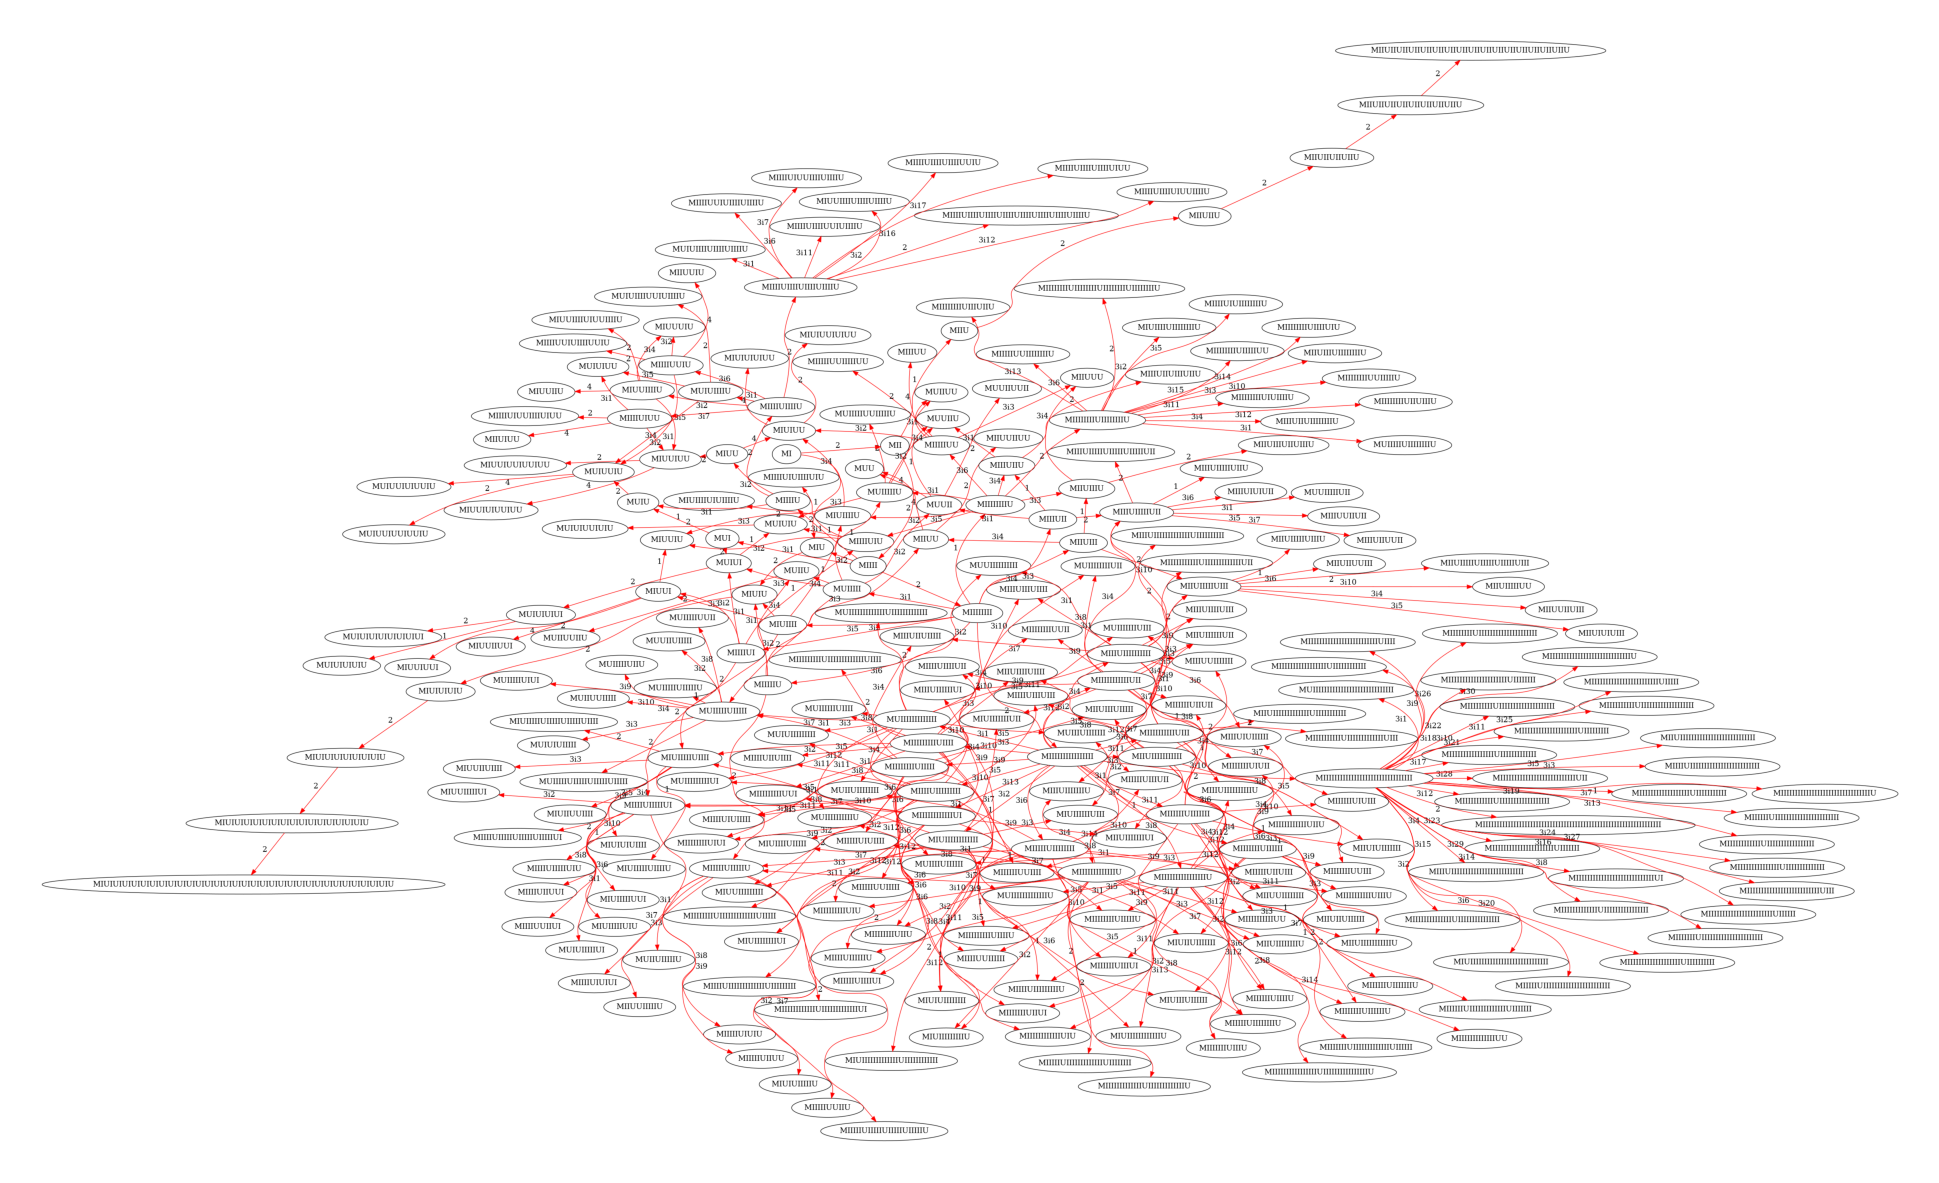

In [16]:
mi = miuPuzzle(axiom='MI')

network = mi.discover_local_network(string=mi.axiom, num_steps=6)

mi.plot_network(network)